In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Mine/API/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
License(s): Attribution 4.0 International (CC BY 4.0)
cartoon-faces-googles-cartoon-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/cartoon-faces-googles-cartoon-set.zip

Archive:  /content/cartoon-faces-googles-cartoon-set.zip
replace cartoonset100k_jpg/0/cs11502169095236683120.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [6]:
class CartoonData:
    def __init__(self, image_dir, image_size=(64, 64), max_images=8000,batch_size = 64):
        self._data_path = image_dir
        self._img_size = image_size
        self._max_images = max_images
        self._data = None
        self._batch_size = batch_size


    def _load(self):
        images = []
        folders = os.listdir(self._data_path)
        n_folders = len(folders)
        imgs_per_folder = self._max_images // n_folders

        for folder in folders:
            folder_path = os.path.join(self._data_path, folder)
            count = 0

            for image in os.listdir(folder_path):
                if count >= imgs_per_folder:
                    break

                full = os.path.join(folder_path, image)
                img = load_img(full, target_size=self._img_size)
                images.append(img_to_array(img))
                count += 1

        self._data = np.array(images).astype("float32") / 255.0

    def _make_it_batchs(self):
      X_train, X_val = train_test_split(self._data, test_size=0.2, random_state=42)

      training_dataset = tf.data.Dataset.from_tensor_slices(X_train)
      training_dataset = training_dataset.shuffle(1000).batch(self._batch_size)

      val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
      val_dataset = val_dataset.batch(self._batch_size)

      return training_dataset,val_dataset

    def prepare_data(self):
      self._load()
      training_dataset ,val_dataset = self._make_it_batchs()
      return training_dataset,val_dataset


In [7]:
class Sampling(layers.Layer):
    """Reparameterization trick"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(models.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")
        self.conv3 = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")
        self.conv4 = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(256, activation="relu")
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

In [9]:
class Decoder(models.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = layers.Dense(4 * 4 * 256, activation="relu")
        self.reshape = layers.Reshape((4, 4, 256))
        self.deconv1 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")
        self.deconv2 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")
        self.deconv3 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")
        self.deconv4 = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")
        self.out = layers.Conv2D(3, 3, padding="same", activation="sigmoid")

    def call(self, z):
        x = self.fc(z)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return self.out(x)


In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1,2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1,2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = recon_loss + kl_loss


        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }


In [11]:
class VAEVisualizer:
    @staticmethod
    def show(images, rows, cols, title="Images"):
        """
        Generic image grid display
        images: numpy array or list of images (H,W,C)
        """
        plt.figure(figsize=(cols * 2, rows * 2))
        for i in range(rows * cols):
            if i >= len(images):
                break
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i])
            plt.axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()


    @staticmethod
    def generate(decoder, latent_dim, n=16):
        """Generate new images from random latent vectors"""
        z = np.random.normal(size=(n, latent_dim))
        return decoder.predict(z)

    @staticmethod
    def plot_history(history):
        """Plot training history: total loss and components"""
        plt.figure(figsize=(12, 4))

        # Total loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['total_loss'], label="Train Total Loss")
        plt.plot(history.history['val_total_loss'], label="Val Total Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Total Loss")
        plt.legend()
        plt.grid(True)

        # Loss components
        plt.subplot(1, 2, 2)
        plt.plot(history.history['reconstruction_loss'], label="Train Recon Loss")
        plt.plot(history.history['kl_loss'], label="Train KL Loss")
        plt.plot(history.history['val_reconstruction_loss'], label="Val Recon Loss")
        plt.plot(history.history['val_kl_loss'], label="Val KL Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Components")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def show_original_vs_reconstructed(encoder, decoder, images, n_samples=10):
        """Display original images vs reconstructed images"""
        sample = img_train.unbatch().take(n_samples)
        samples = [image for image in sample]
        samples = np.array(samples)
        _, _, z = encoder.predict(samples)
        reconstructed = decoder.predict(z)

        plt.figure(figsize=(20, 4))
        for i in range(n_samples):
            # Original
            plt.subplot(2, n_samples, i + 1)
            plt.imshow(samples[i])
            plt.axis("off")
            # Reconstructed
            plt.subplot(2, n_samples, n_samples + i + 1)
            plt.imshow(reconstructed[i])
            plt.axis("off")
        plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
        plt.show()

    @staticmethod
    def show_generated(decoder, latent_dim, n=16):
        """Generate and display new images"""
        generated = VAEVisualizer.generate(decoder, latent_dim, n)
        rows = int(np.sqrt(n))
        cols = int(np.ceil(n / rows))
        VAEVisualizer.show(generated, rows, cols, title="Generated Images")


In [12]:
DATA_PATH = '/content/cartoonset100k_jpg'
LATENT_DIM = 32
EPOCHS = 25
BATCH_SIZE = 64

In [13]:
dataset = CartoonData(DATA_PATH, max_images=50000,batch_size = BATCH_SIZE)
img_train , img_val = dataset.prepare_data()

In [14]:
sample = img_train.unbatch().take(25)
sample = [image for image in sample]

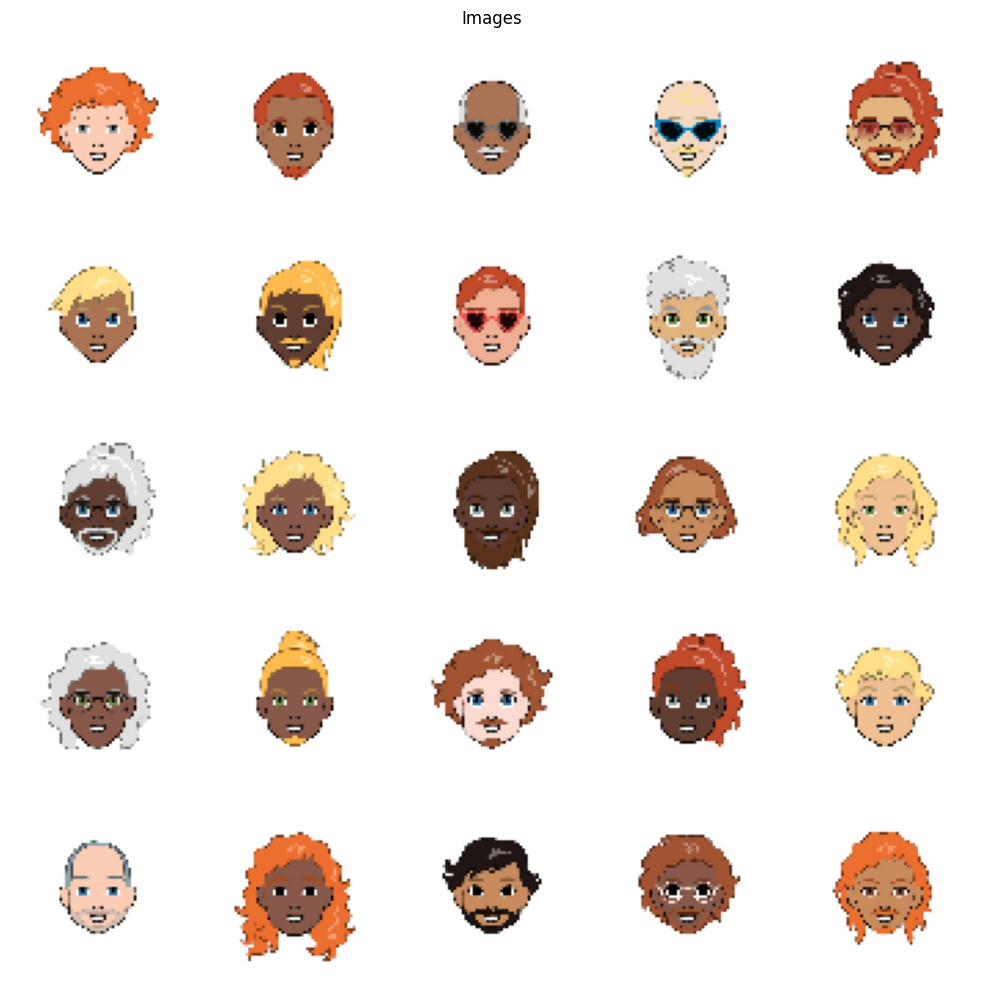

In [15]:
VAEVisualizer.show(sample,5,5)

In [16]:
encoder = Encoder(LATENT_DIM)
decoder = Decoder(LATENT_DIM)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))


In [17]:
history = vae.fit(
    img_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(img_val,)
)



Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - kl_loss: 16.2469 - reconstruction_loss: 957.2889 - total_loss: 973.5360 - val_kl_loss: 24.0938 - val_reconstruction_loss: 606.6021 - val_total_loss: 630.6958
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - kl_loss: 21.7018 - reconstruction_loss: 590.0710 - total_loss: 611.7729 - val_kl_loss: 20.2105 - val_reconstruction_loss: 561.2367 - val_total_loss: 581.4473
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - kl_loss: 20.5259 - reconstruction_loss: 553.1703 - total_loss: 573.6964 - val_kl_loss: 19.6038 - val_reconstruction_loss: 542.6553 - val_total_loss: 562.2591
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - kl_loss: 19.2618 - reconstruction_loss: 538.2873 - total_loss: 557.5490 - val_kl_loss: 19.2898 - val_reconstruction_loss: 533.7078 - val_total_loss: 552.9976
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - kl_loss: 18.9445 - reconstruction_loss: 531.5288 - total_loss: 550.4733 - val_kl_loss: 1

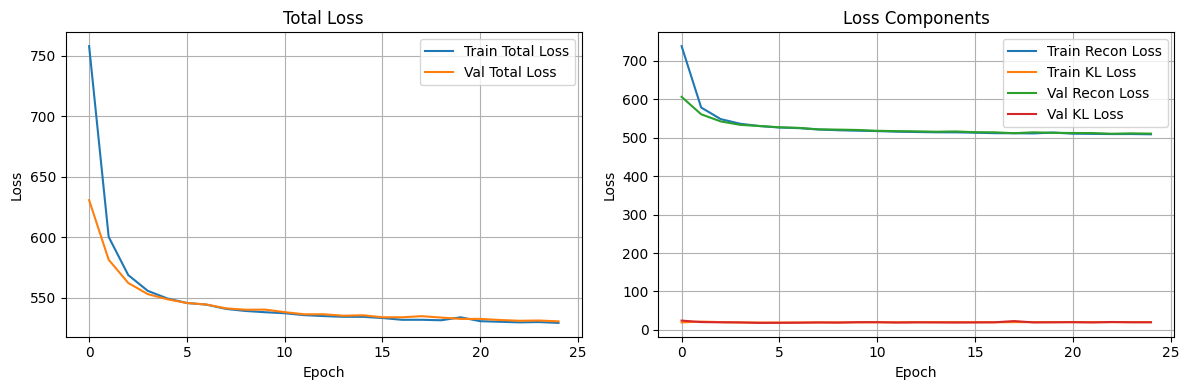

In [18]:
# History plots
VAEVisualizer.plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


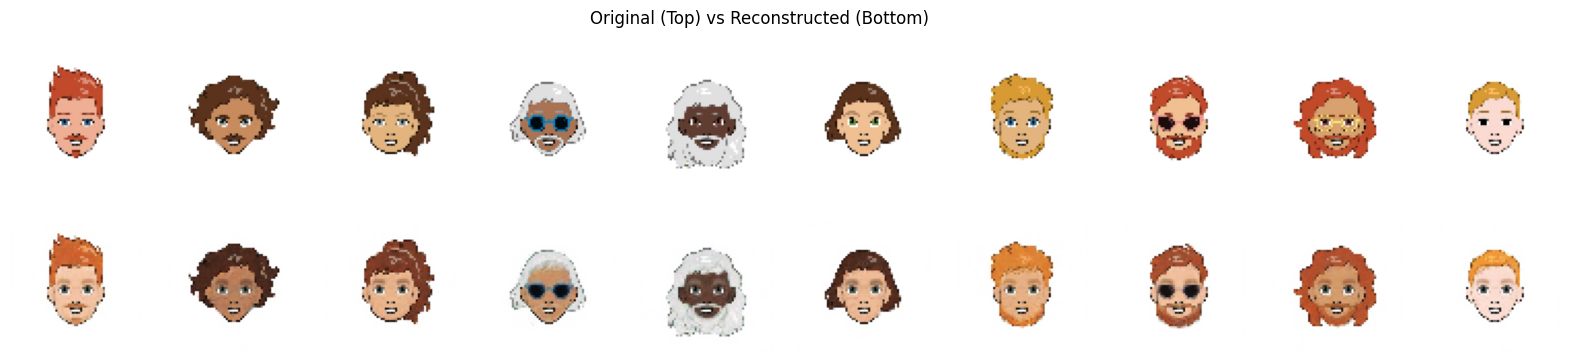

In [19]:

# Original vs Reconstructed
VAEVisualizer.show_original_vs_reconstructed(encoder, decoder, img_val, n_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


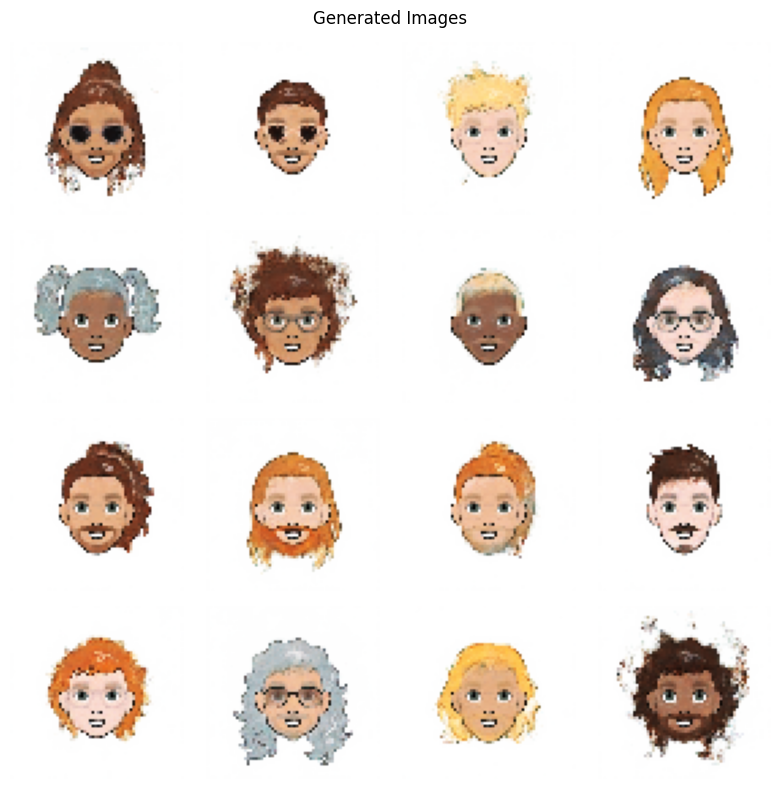

In [20]:

# Generated images
VAEVisualizer.show_generated(decoder, LATENT_DIM, n=16)
